# Câu 1:

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# 1. Tải dữ liệu MNIST
transform = transforms.ToTensor()  # Chuyển ảnh thành tensor
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)


In [3]:
# 2. Định nghĩa mô hình CNN
class MNIST_CNN(nn.Module):  # Tạo lớp MNIST_CNN kế thừa từ nn.Module (lớp cơ bản của PyTorch)
    def __init__(self):  # Hàm khởi tạo mô hình
        super(MNIST_CNN, self).__init__()  # Gọi hàm khởi tạo của lớp cha (nn.Module)
        # Tầng tích chập 1: 1 kênh đầu vào (ảnh đen trắng) -> 16 kênh đầu ra, filter 3x3
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=0)  # Tích chập giảm kích thước từ 28x28 -> 26x26
        # Tầng tích chập 2: 16 kênh đầu vào -> 32 kênh đầu ra, filter 3x3
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=0)  # Tích chập giảm từ 12x12 -> 10x10 (sau pooling)
        # Tầng pooling: vùng 2x2, giảm kích thước một nửa
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Ví dụ: 26x26 -> 13x13, 10x10 -> 5x5
        # Tầng fully connected: từ 32 kênh * 5x5 (800) -> 10 lớp (0-9)
        self.fc1 = nn.Linear(32 * 5 * 5, 10)  # Duỗi feature map thành vector rồi phân loại

    def forward(self, x):  # Hàm forward định nghĩa luồng dữ liệu qua các tầng
        x = self.pool(torch.relu(self.conv1(x)))  # Conv1 -> ReLU (loại giá trị âm) -> Pool (giảm kích thước)
        x = self.pool(torch.relu(self.conv2(x)))  # Conv2 -> ReLU -> Pool, cuối cùng ra 32x5x5
        x = x.view(-1, 32 * 5 * 5)  # Duỗi tensor thành vector, -1 tự động tính batch size
        x = self.fc1(x)  # Qua tầng fully connected, ra 10 giá trị (logits cho 0-9)
        return x  # Trả về kết quả dự đoán

In [4]:
# Khởi tạo mô hình
model = MNIST_CNN()  # Tạo một instance của lớp MNIST_CNN
criterion = nn.CrossEntropyLoss()  # Định nghĩa hàm mất mát CrossEntropy (dùng cho phân loại nhiều lớp)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)  # Dùng SGD với learning rate 0.01 và momentum 0.9 để tối ưu

In [5]:
# 3. Huấn luyện mô hình
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Chọn GPU nếu có, không thì dùng CPU
model.to(device)  # Chuyển mô hình sang thiết bị đã chọn (GPU/CPU)

loss_values = []  # Tạo list để lưu giá trị mất mát trung bình của mỗi epoch
for epoch in range(5): # Lặp qua 5 epoch (mỗi epoch là một lần duyệt hết dữ liệu)
    running_loss = 0.0  # Biến để cộng dồn mất mát trong epoch
    for images, labels in train_loader:  # Lặp qua từng batch trong tập huấn luyện
        images, labels = images.to(device), labels.to(device)  # Chuyển ảnh và nhãn sang GPU/CPU
        
        optimizer.zero_grad()  # Xóa gradient cũ để tránh tích lũy từ bước trước
        outputs = model(images)  # Đưa ảnh qua mô hình, nhận dự đoán (logits)
        loss = criterion(outputs, labels)  # Tính mất mát giữa dự đoán và nhãn thật
        loss.backward()  # Tính gradient ngược (backpropagation)
        optimizer.step()  # Cập nhật trọng số dựa trên gradient
        
        running_loss += loss.item()  # Cộng dồn giá trị mất mát của batch
    epoch_loss = running_loss / len(train_loader)  # Tính mất mát trung bình của epoch
    loss_values.append(epoch_loss)  # Lưu mất mát trung bình vào list
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")  # In mất mát trung bình sau mỗi epoch


Epoch 1, Loss: 0.2733
Epoch 2, Loss: 0.0893
Epoch 3, Loss: 0.0678
Epoch 4, Loss: 0.0560
Epoch 5, Loss: 0.0497


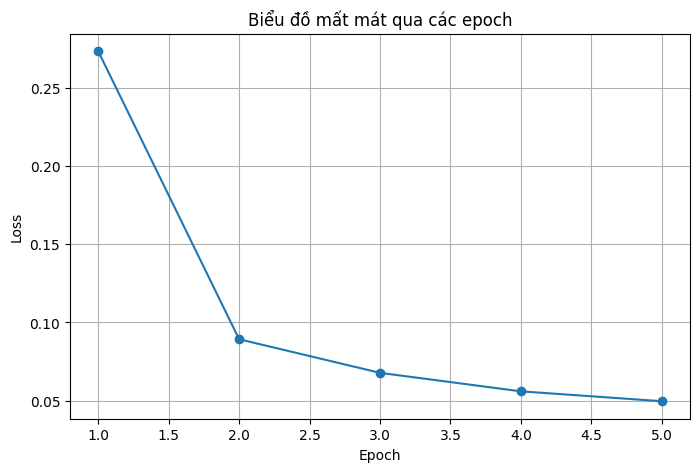

In [6]:
# Vẽ biểu đồ loss
plt.figure(figsize=(8, 5))  # Tạo khung hình kích thước 8x5
plt.plot(range(1, 6), loss_values, marker='o')  # Vẽ đường mất mát qua 5 epoch, thêm điểm đánh dấu
plt.title("Biểu đồ mất mát qua các epoch")  # Tiêu đề biểu đồ
plt.xlabel("Epoch")  # Nhãn trục x
plt.ylabel("Loss")  # Nhãn trục y
plt.grid(True)  # Thêm lưới để dễ nhìn
plt.show()  # Hiển thị biểu đồ

In [7]:
correct = 0  # Đếm số dự đoán đúng
total = 0  # Đếm tổng số mẫu
with torch.no_grad():  # Tắt tính gradient vì chỉ đánh giá, không huấn luyện
    for images, labels in test_loader:  # Lặp qua từng batch trong tập kiểm tra
        images, labels = images.to(device), labels.to(device)  # Chuyển dữ liệu sang GPU/CPU
        outputs = model(images)  # Dự đoán trên batch ảnh
        _, predicted = torch.max(outputs.data, 1)  # Lấy chỉ số lớp có giá trị lớn nhất (dự đoán)
        total += labels.size(0)  # Cộng số mẫu trong batch vào tổng
        correct += (predicted == labels).sum().item()  # Cộng số dự đoán đúng
print(f"Độ chính xác trên tập test: {100 * correct / total:.2f}%")  # Tính và in độ chính xác (%)

Độ chính xác trên tập test: 98.26%


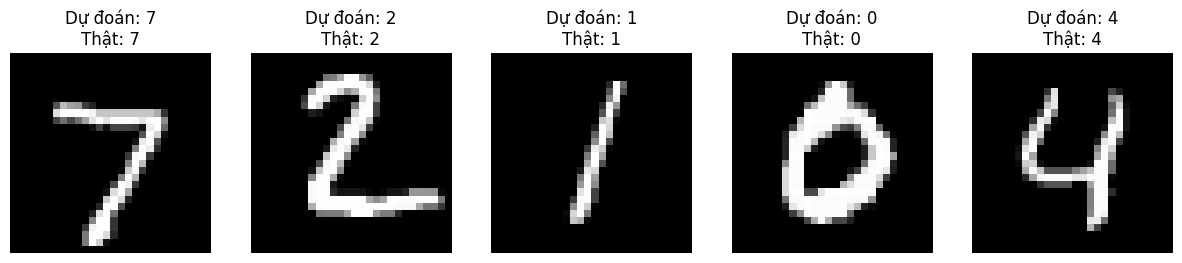

In [8]:
# Trực quan kết quả dự đoán
def visualize_prediction():  # Hàm để vẽ 5 ảnh và dự đoán
    model.eval()  # Chuyển mô hình sang chế độ đánh giá (tắt dropout, batch norm nếu có)
    images, labels = next(iter(test_loader))  # Lấy một batch từ tập kiểm tra
    images, labels = images.to(device), labels.to(device)  # Chuyển sang GPU/CPU
    outputs = model(images)  # Dự đoán trên batch
    _, predicted = torch.max(outputs, 1)  # Lấy chỉ số lớp dự đoán
    
    # Vẽ 5 ảnh đầu tiên
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))  # Tạo lưới 1x5 để vẽ 5 ảnh
    for i in range(5):  # Lặp qua 5 ảnh đầu
        axes[i].imshow(images[i].cpu().squeeze(), cmap='gray')  # Vẽ ảnh (chuyển về CPU, bỏ kênh 1)
        axes[i].set_title(f"Dự đoán: {predicted[i].item()}\nThật: {labels[i].item()}")  # Ghi nhãn dự đoán và thật
        axes[i].axis('off')  # Tắt trục tọa độ
    plt.show()  # Hiển thị hình

visualize_prediction()  # Gọi hàm để vẽ

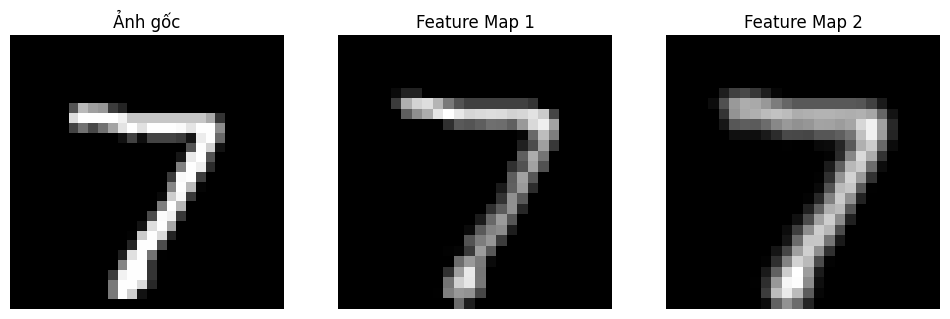

In [9]:
#Trực quan feature map
def visualize_feature_map():  # Hàm để vẽ ảnh gốc và feature map từ tầng conv1
    model.eval()  # Chuyển sang chế độ đánh giá
    images, _ = next(iter(test_loader))  # Lấy một batch từ tập kiểm tra (bỏ nhãn)
    img = images[0].unsqueeze(0).to(device)  # Lấy ảnh đầu tiên, thêm chiều batch (1x1x28x28)
    
    # Tính feature map từ conv1
    conv1_output = torch.relu(model.conv1(img))  # Qua conv1 và ReLU, ra tensor 1x16x26x26
    
    # Vẽ ảnh gốc và feature map
    plt.figure(figsize=(12, 4))  
    plt.subplot(1, 3, 1)  
    plt.title("Ảnh gốc")  
    plt.imshow(img.cpu().squeeze(), cmap='gray') 
    plt.axis('off')  
    
    # Vẽ feature map đầu tiên
    plt.subplot(1, 3, 2)  
    plt.title("Feature Map 1")  
    plt.imshow(conv1_output[0, 0].cpu().detach().numpy(), cmap='gray')  
    plt.axis('off')  
    
    # Vẽ feature map thứ hai
    plt.subplot(1, 3, 3)  
    plt.title("Feature Map 2") 
    plt.imshow(conv1_output[0, 1].cpu().detach().numpy(), cmap='gray')  
    plt.axis('off') 
    plt.show() 

visualize_feature_map()  